In [1]:
# Authors: Samantha Tetef and Vikram Kashyap
# Date: Winter 2020-2021 to Summer 2021

In [111]:
import warnings
warnings.filterwarnings("ignore")

import newutils as u
from importlib import reload
# to reload utils, run:
# u = reload(u)

import os
import copy
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
import mplcursors
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from pathlib import Path
from collections import defaultdict

import webbrowser

warnings.filterwarnings("ignore")

In [112]:
u = reload(u)

In [3]:
%matplotlib notebook

In [4]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
   return false;
}

<IPython.core.display.Javascript object>

In [11]:
ROOTDIR = Path()

DataDir = ROOTDIR/"ProcessedData"
ListDir = ROOTDIR/"Categories"

X_data = u.get_Data(ListDir)

print(len(X_data))

770


# ML and Data Science section

In [32]:
CIDs = [c['CID'] for c in X_data]

compoundmap = {c['CID']:c for c in X_data}
typecodemap = {compound['CID']:compound['Type'] for compound in X_data}
classcodemap = {compound['CID']:u.CLASSCODES[compound['Class']] for compound in X_data}
colormap_bytype = {compound['CID']:u.colorbynumber(typecodemap[compound['CID']]) for compound in X_data}

## All Spectra Together

<IPython.core.display.Javascript object>


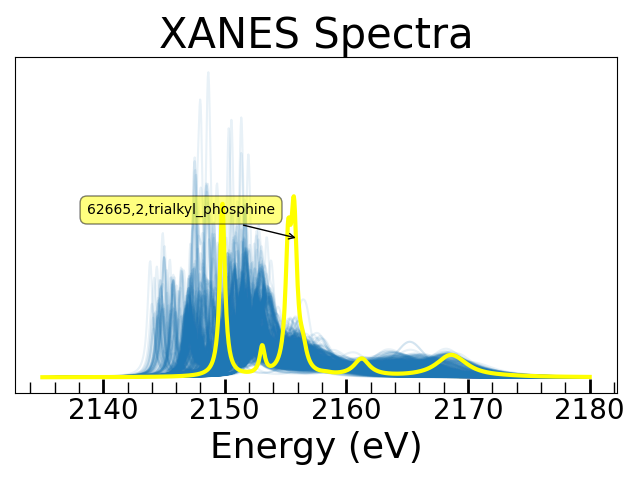

<IPython.core.display.Javascript object>


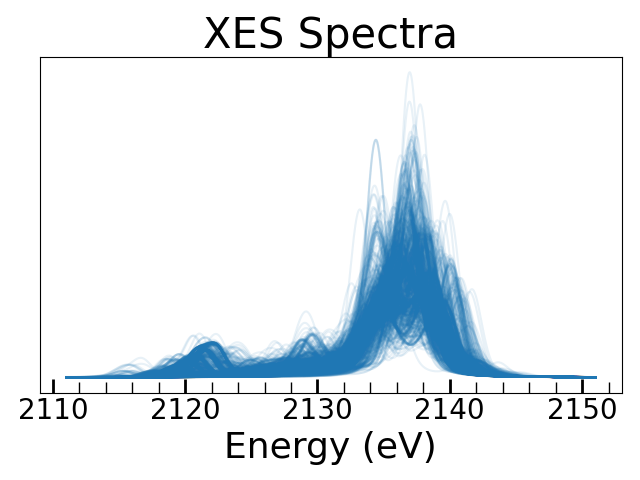

In [110]:
u.add_line_label(u.plot_spaghetti(plt.subplots(), X_data, mode='XANES', coloralpha=0.1),X_data);
u.plot_spaghetti(plt.subplots(), X_data, mode='XES', coloralpha=0.1);

## Rainbow Spaghetti Plot: Color by Compound Type

<IPython.core.display.Javascript object>


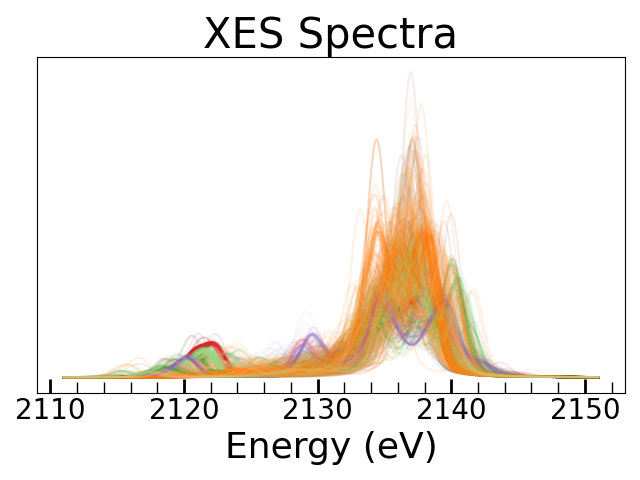

In [87]:
u.plot_spaghetti(plt.subplots(), X_data, colorcodemap=typecodemap, mode='XES', coloralpha=0.1);

## Rainbow Spaghetti Plot: Color and Stack by Compound Type

<IPython.core.display.Javascript object>


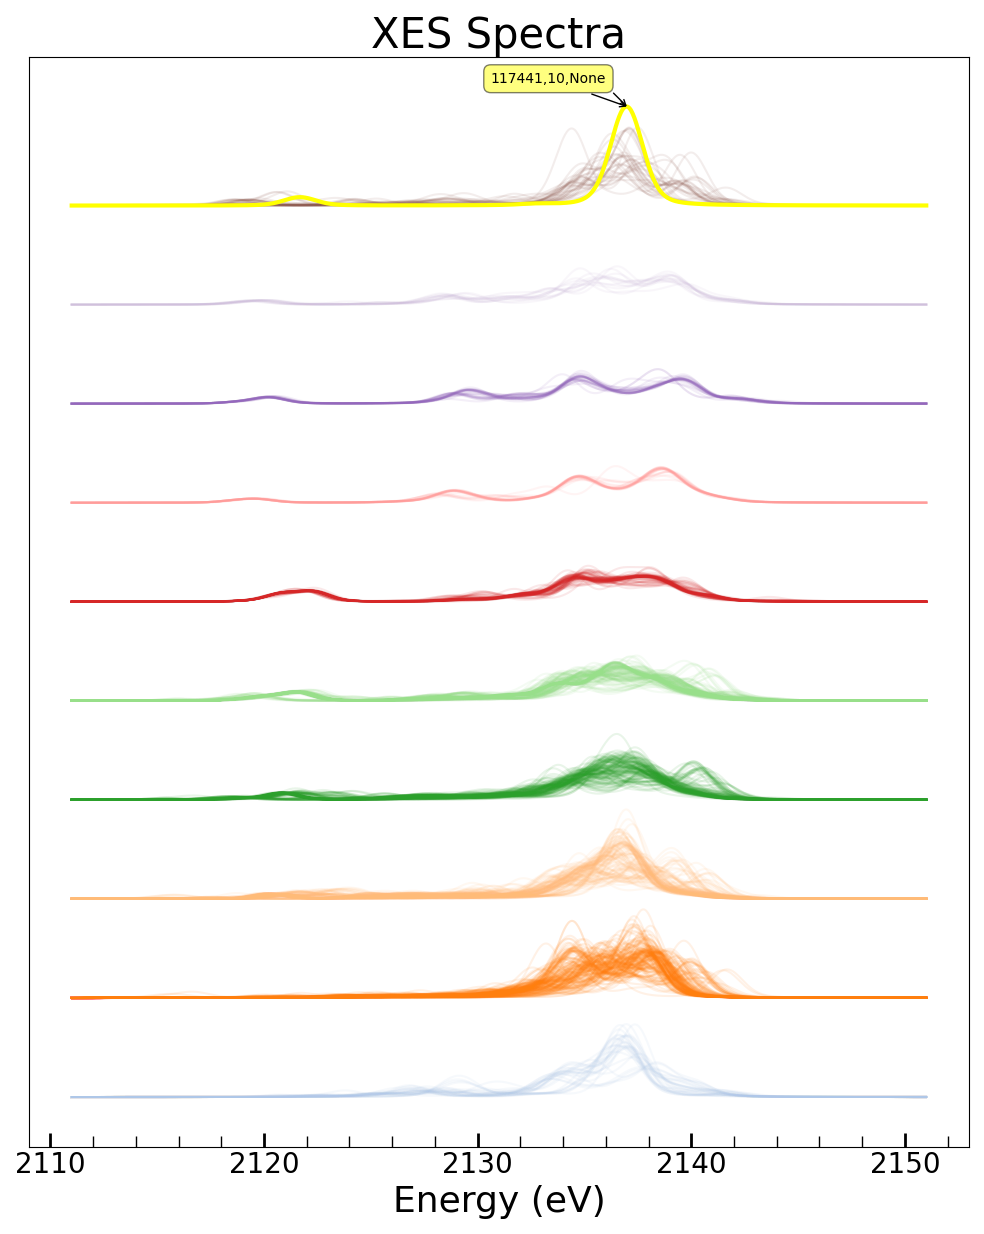

<IPython.core.display.Javascript object>


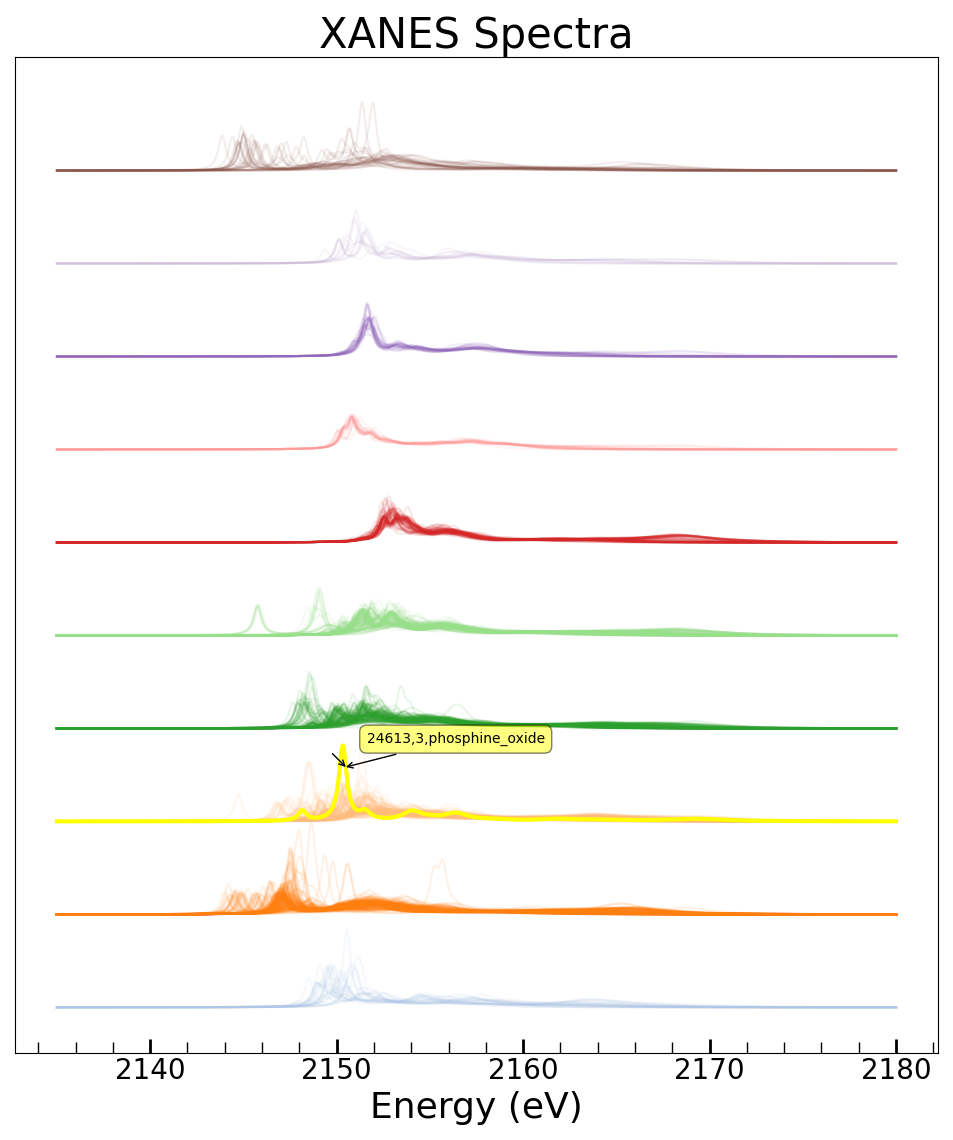

In [102]:
xes_stackplot = u.plot_spaghetti(plt.subplots(), X_data, \
        colorcodemap=typecodemap, binmap=typecodemap, mode='XES', coloralpha=0.1);
xanes_stackplot = u.plot_spaghetti(plt.subplots(), X_data, \
        colorcodemap=typecodemap, binmap=typecodemap, mode='XANES', coloralpha=0.1);

u.add_line_label(xes_stackplot, X_data)
u.add_line_label(xanes_stackplot, X_data)
u.add_line_pubchem_link(xanes_stackplot, X_data)
u.add_line_pubchem_link(xes_stackplot, X_data)

In [91]:
def plot_cid_with_class(plot, focus_cid, compoundmap, hideclass=False, **kwargs):
    focus_class = compoundmap[focus_cid]['Class']
    data = [compoundmap[cid] for cid in compoundmap if compoundmap[cid]['Class']==focus_class]
    if hideclass:
        hidden_cids = [c['CID'] for c in data if c['CID']!=focus_cid]
    else: hidden_cids = []
    u.plot_spaghetti(plot, data, hiddencids=hidden_cids, **kwargs)

In [108]:
compoundmap[5520]['Class']

'phosphinate'

<IPython.core.display.Javascript object>


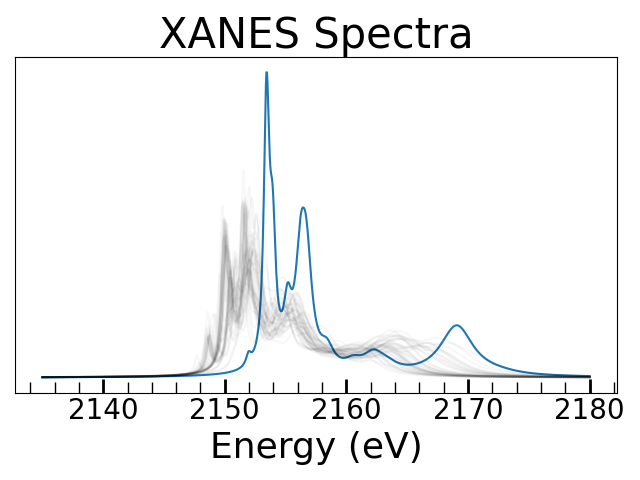

<IPython.core.display.Javascript object>


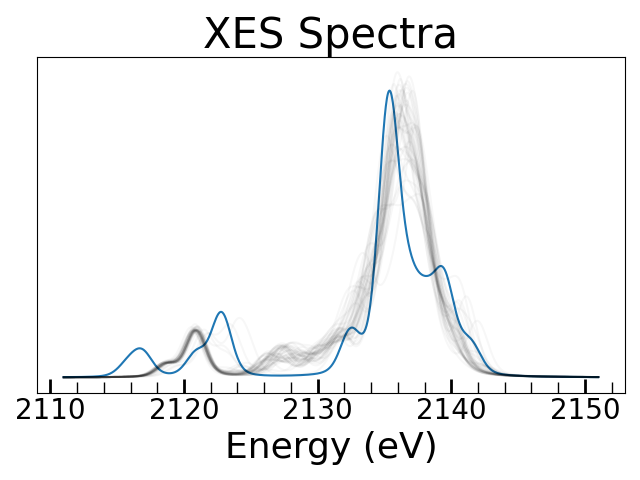

In [106]:
cid = 61681
plot_cid_with_class(plt.subplots(), cid, compoundmap, mode='XANES', hideclass=True, hiddenalpha=0.03)
plot_cid_with_class(plt.subplots(), cid, compoundmap, mode='XES', hideclass=True, hiddenalpha=0.03)

## ML Reduced Space: PCA and T-SNE

In [24]:
warnings.filterwarnings("ignore")

XES = [compound['XES_Normalized'] for compound in X_data]
XANES = [compound['XANES_Normalized'] for compound in X_data]

# pca
pca1 = PCA(n_components=10)
XES_PCA = pca1.fit_transform(XES)

# pca
pca2 = PCA(n_components=10)
XANES_PCA = pca2.fit_transform(XANES)

# tsne
tsne = TSNE(n_components=2, perplexity=20)
XES_TSNE = tsne.fit_transform(XES)

# tsne
tsne = TSNE(n_components=2, perplexity=20, random_state=30)
XANES_TSNE = tsne.fit_transform(XANES)


# Make CID->point maps
XANES_tsnemap = {compound['CID']:point for compound,point in zip(X_data, XANES_TSNE)}
XES_tsnemap = {compound['CID']:point for compound,point in zip(X_data, XES_TSNE)}

<IPython.core.display.Javascript object>


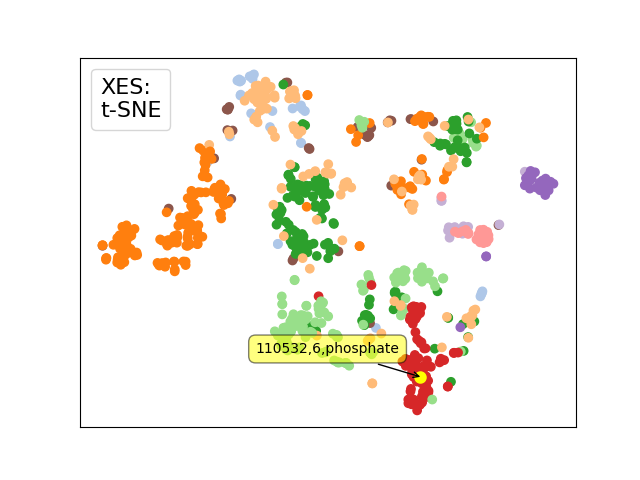

<IPython.core.display.Javascript object>


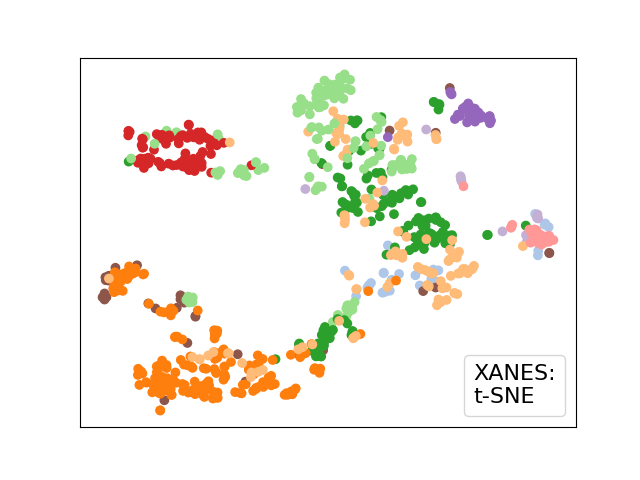

In [27]:
xesplot = u.plot_dim_red(plt.subplots(), X_data, XES_tsnemap, colorcodemap=typecodemap, mode='XES', method='t-SNE')
xanesplot = u.plot_dim_red(plt.subplots(), X_data, XANES_tsnemap, colorcodemap=typecodemap, mode='XANES', method='t-SNE')

u.add_point_label(xesplot, X_data)
u.add_point_label(xanesplot, X_data)

## Reduced Space: Algorithmic Clustering

In [30]:
from sklearn.cluster import DBSCAN

In [28]:
# Assigns clustermap vars
def runclustering(new_eps, new_min_samples=1):
    global XANES_clustering, XANES_clustermap, XES_clustering, XES_clustermap
    XANES_clustering = DBSCAN(eps=new_eps, min_samples=new_min_samples).fit(XANES_TSNE)
    XANES_clustermap = {compound['CID']:cluster for compound,cluster in zip(XANES_data, XANES_clustering.labels_)}

    XES_clustering = DBSCAN(eps=new_eps, min_samples=new_min_samples).fit(XES_TSNE)
    XES_clustermap = {compound['CID']:cluster for compound,cluster in zip(XES_data, XES_clustering.labels_)}

In [31]:
runclustering(3)

<IPython.core.display.Javascript object>


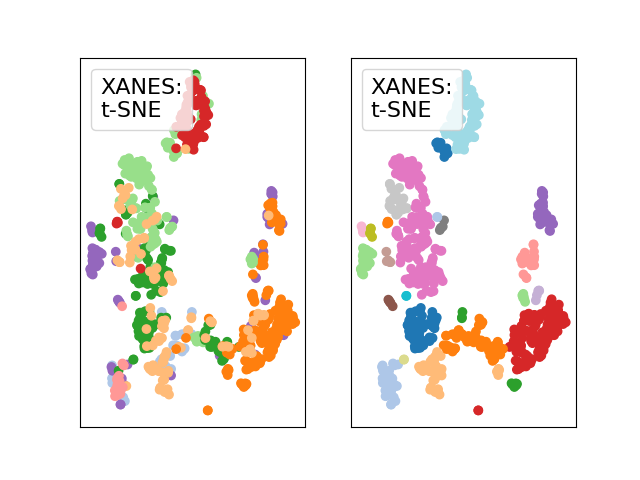

In [32]:
fig, axes = plt.subplots(1,2)
subplots = [(fig, ax) for ax in axes]

redspace_dots_clustered = u.plot_dim_red(subplots[0], X_data, XANES_tsnemap, typecodemap, mode='XANES')

redspace_dots_categorized = u.plot_dim_red(subplots[1], X_data, XANES_tsnemap, XANES_clustermap, mode='XANES')

<IPython.core.display.Javascript object>


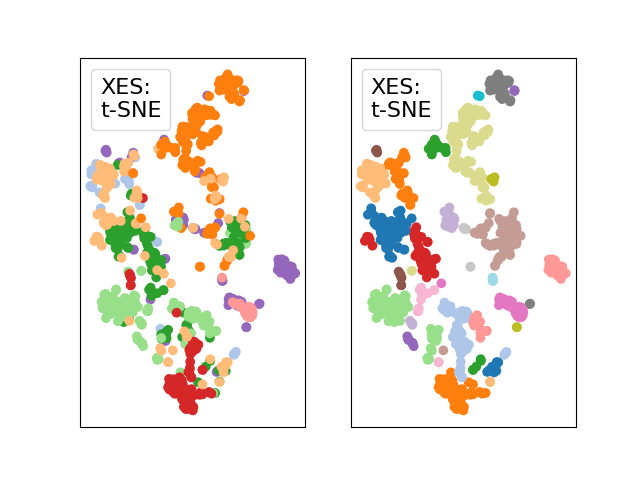

In [33]:
fig, axes = plt.subplots(1,2)
subplots = [(fig, ax) for ax in axes]

redspace_dots_clustered = u.plot_dim_red(subplots[0], X_data, XES_tsnemap, typecodemap, mode='XES')

redspace_dots_categorized = u.plot_dim_red(subplots[1], X_data, XES_tsnemap, XES_clustermap, mode='XES')

<IPython.core.display.Javascript object>


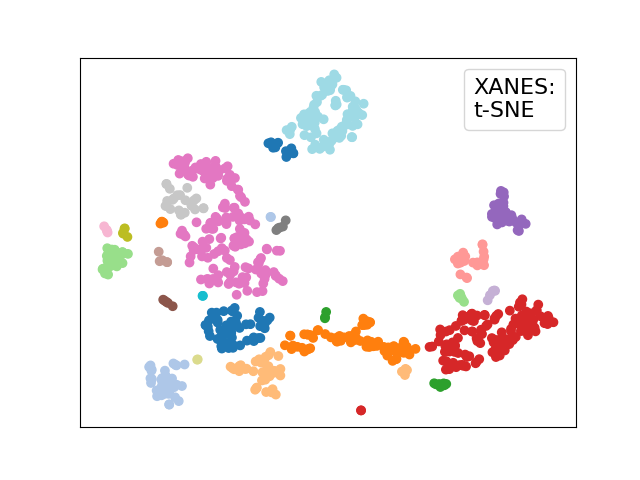

In [34]:
redspace_dots_categorized = u.plot_dim_red(plt.subplots(), X_data, XANES_tsnemap, XANES_clustermap, mode='XANES')

## Download Structure Diagrams

## Compare Clusters within Type

<IPython.core.display.Javascript object>


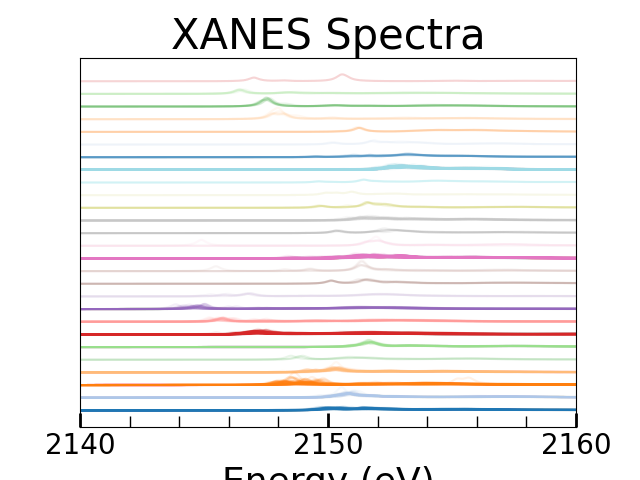

In [35]:
u.plot_spaghetti(plt.subplots(), X_data, binmap=XANES_clustermap, colormap=XANES_clustermap, mode='XANES', coloralpha=0.1, energyrange=[2140,2160]);

<IPython.core.display.Javascript object>


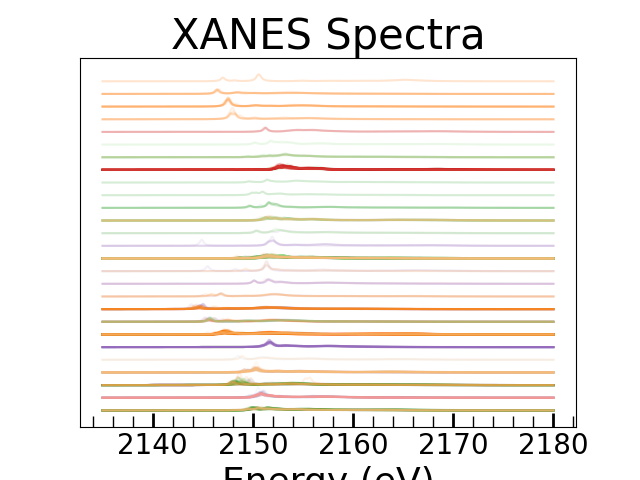

In [36]:
u.plot_spaghetti(plt.subplots(), X_data, binmap=XANES_clustermap, colormap=typecodemap, mode='XANES', coloralpha=0.1);

<IPython.core.display.Javascript object>


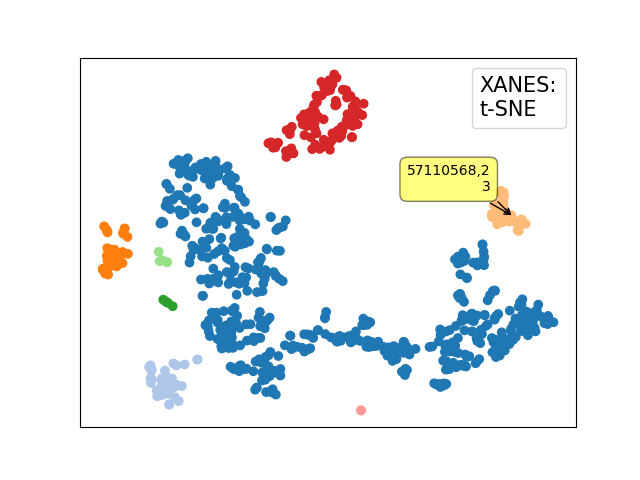

In [37]:
runclustering(5)
plot = u.plot_dim_red(plt.subplots(), X_data, XANES_tsnemap, colormap=XANES_clustermap, mode=f'XANES', fontsize=15)
u.add_pubchem_link(plot, X_data)
u.add_label(plot, X_data, XANES_clustermap)

<IPython.core.display.Javascript object>


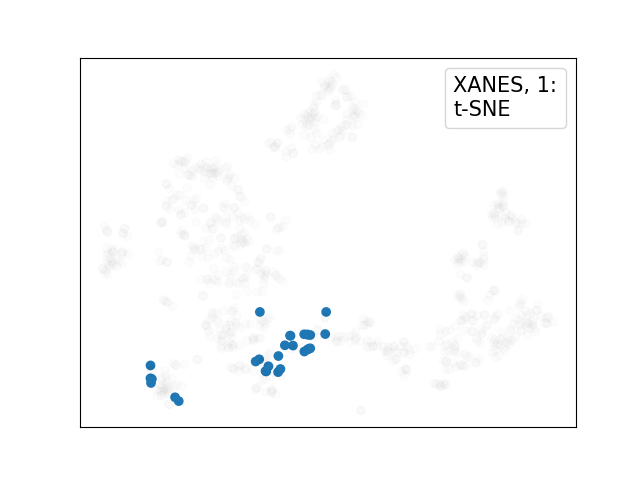

<IPython.core.display.Javascript object>


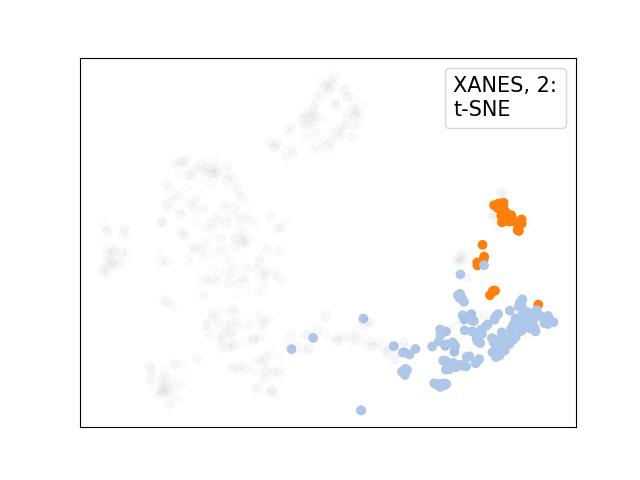

<IPython.core.display.Javascript object>


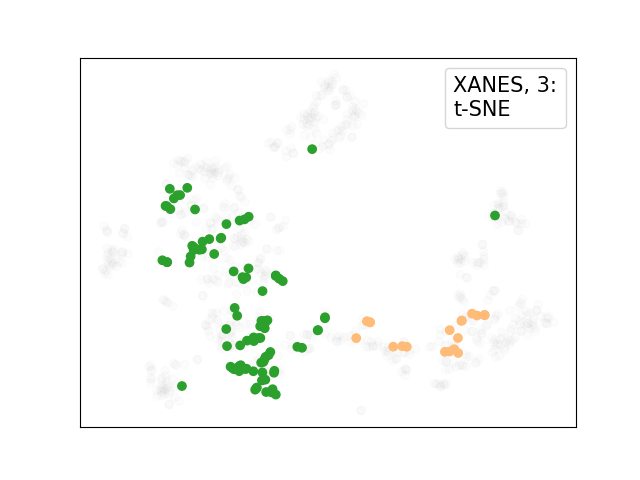

<IPython.core.display.Javascript object>


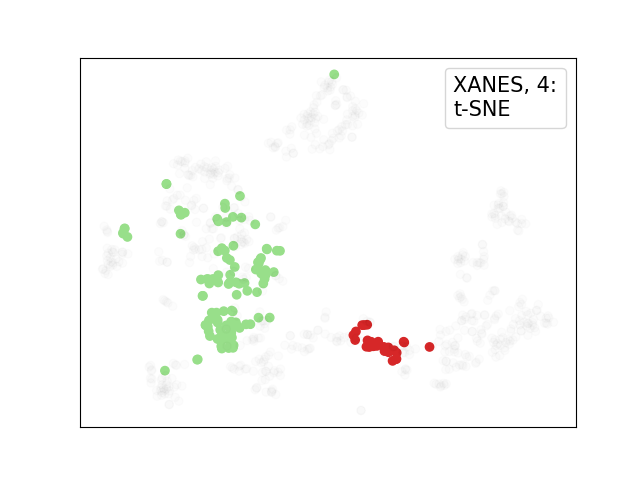

<IPython.core.display.Javascript object>


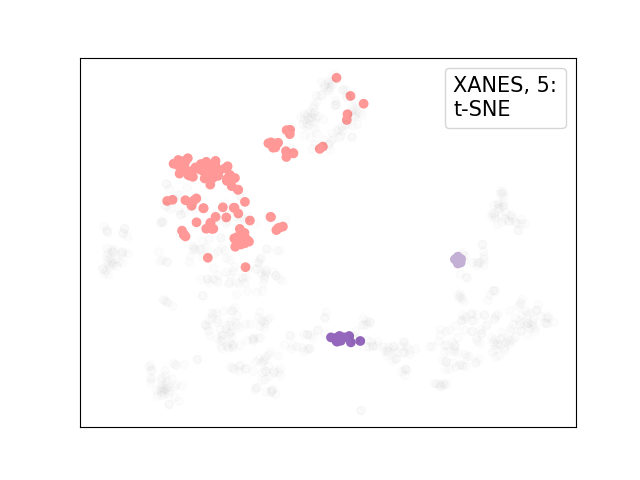

<IPython.core.display.Javascript object>


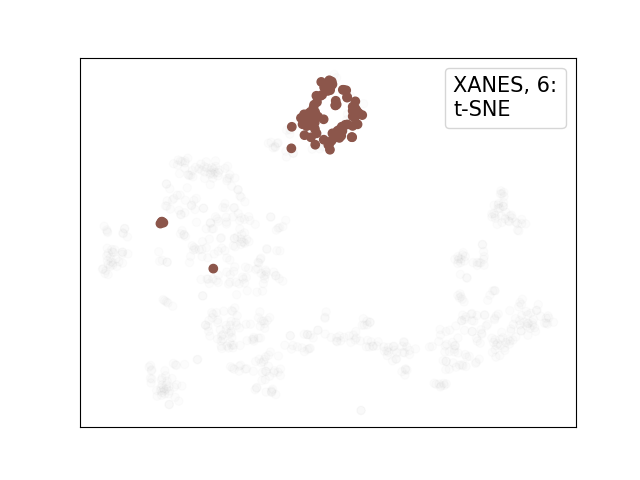

<IPython.core.display.Javascript object>


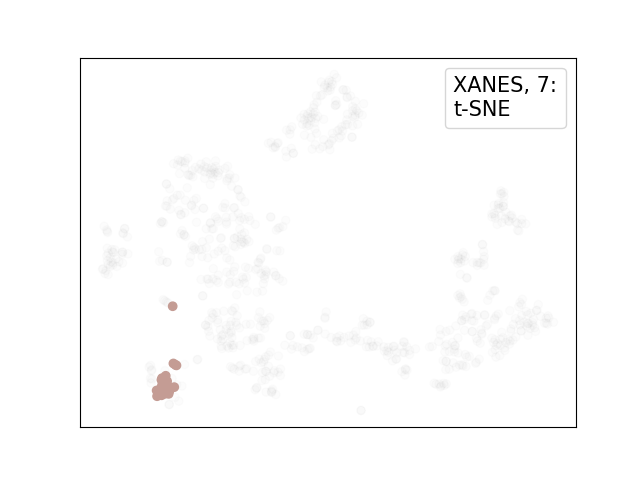

In [39]:
runclustering(3)
for t in range(1,8):
    hidecids = [c['CID'] for c in X_data if c['Type']!=t]
    plot = u.plot_dim_red(plt.subplots(), X_data, XANES_tsnemap, colormap=classcodemap, hiddencids=hidecids, mode=f'XANES, {t}', fontsize=15)
    u.add_pubchem_link(plot, X_data)
    u.add_label(plot, X_data, XANES_clustermap)

<IPython.core.display.Javascript object>


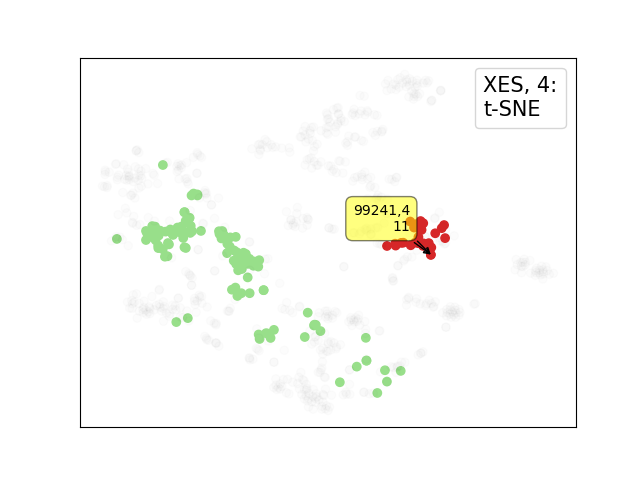

In [40]:
hidecids = [c['CID'] for c in XES_data if c['Type']!=4]
plot = u.plot_dim_red(plt.subplots(), X_data, XES_tsnemap, colormap=classcodemap, hiddencids=hidecids, mode=f'XES, {4}', fontsize=15)
u.add_pubchem_link(plot, X_data)
u.add_label(plot, X_data, XES_clustermap)

### Isolated Clusters

<IPython.core.display.Javascript object>


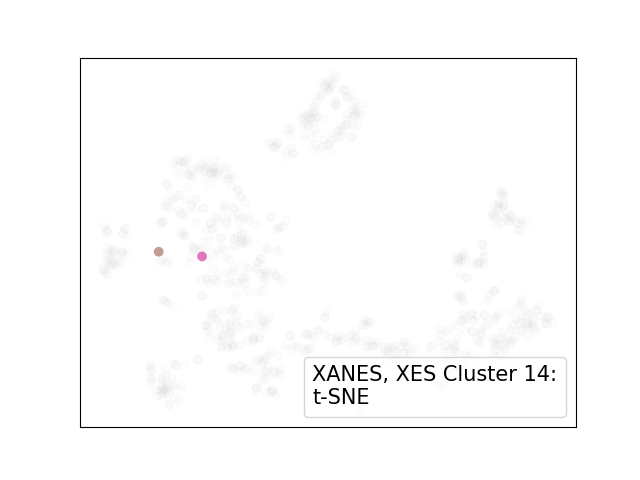

In [41]:
cluster=14
hidecids = [c['CID'] for c in X_data if XES_clustermap[c['CID']]!=cluster]
plot = u.plot_dim_red(plt.subplots(), X_data, XANES_tsnemap, colormap=XANES_clustermap, hiddencids=hidecids, mode=f'XANES, XES Cluster {cluster}', fontsize=15)

<IPython.core.display.Javascript object>


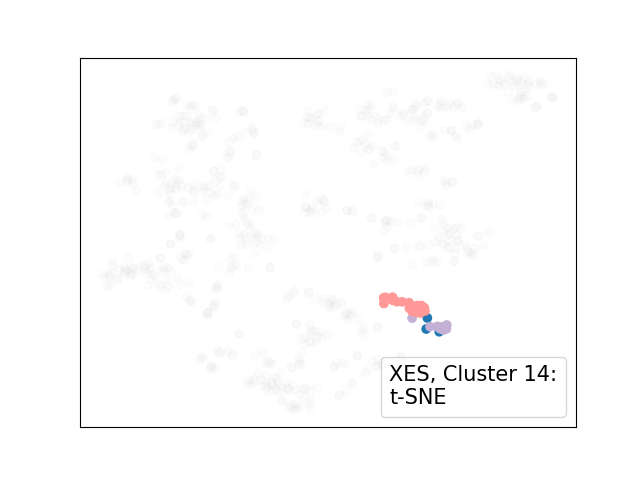

In [173]:
cluster=14
hidecids = [c['CID'] for c in XES_data if XES_clustermap[c['CID']]!=cluster]
plot = u.plot_dim_red(plt.subplots(), XES_data, XES_tsnemap, colormap=classcodemap, hiddencids=hidecids, mode=f'XES, Cluster {cluster}', fontsize=15)
u.add_pubchem_link(plot, XES_data)
u.add_label(plot, XES_data, XES_clustermap)

<IPython.core.display.Javascript object>


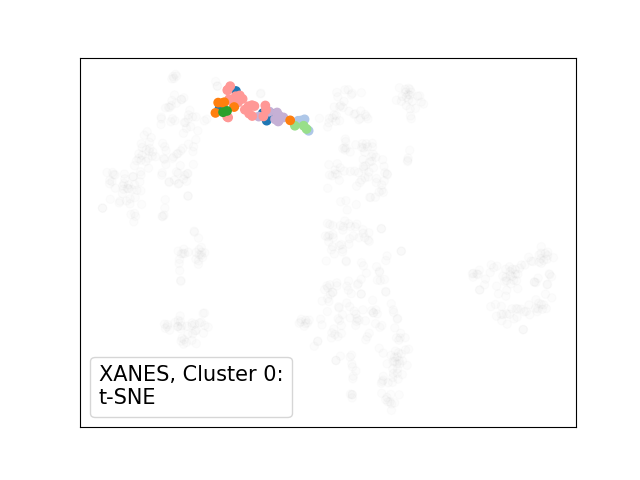

In [172]:
cluster=0
hidecids = [c['CID'] for c in XANES_data if XANES_clustermap[c['CID']]!=cluster]
plot = u.plot_dim_red(plt.subplots(), XANES_data, XANES_tsnemap, colormap=classcodemap, hiddencids=hidecids, mode=f'XANES, Cluster {cluster}', fontsize=15)
u.add_pubchem_link(plot, XANES_data)
u.add_label(plot, XANES_data, XANES_clustermap)

## Group Isolated Spaghetti Plots

<IPython.core.display.Javascript object>


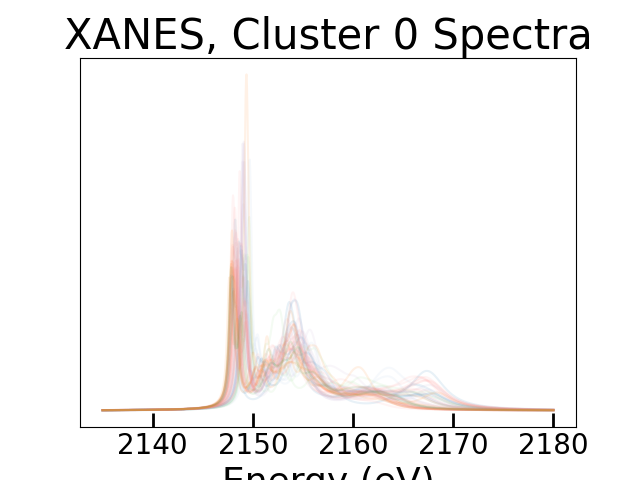

In [81]:
allowedclusters = (0,)
isolated_XANES_data = [c for c in XANES_data if XANES_clustermap[c['CID']] in allowedclusters]
u.plot_spaghetti(plt.subplots(), isolated_XANES_data, binmap=XANES_clustermap, colormap=classcodemap, mode=f"XANES, Cluster {allowedclusters[0]}", coloralpha=0.1);

In [91]:
cids0 = set([c['CID'] for c in XANES_data if XANES_clustermap[c['CID']]==0])
cids1 = set([c['CID'] for c in XANES_data if XANES_clustermap[c['CID']]==1])
cids14 = set([c['CID'] for c in XES_data if XES_clustermap[c['CID']]==14])
cids19 = set([c['CID'] for c in XES_data if XES_clustermap[c['CID']]==19])

In [111]:
l = list(cids1.intersection(cids14))
for i in range(0,len(l)):
    webbrowser.open(f"https://pubchem.ncbi.nlm.nih.gov/image/imgsrv.fcgi?cid={l[i]}&t=l")

In [103]:
len(cids1)

23

In [101]:
cids14.difference(cids1)

{17304,
 17305,
 17522,
 19657,
 25843,
 31200,
 31354,
 104781,
 115123,
 165212,
 168140,
 170990,
 3034435,
 101572300}

<IPython.core.display.Javascript object>


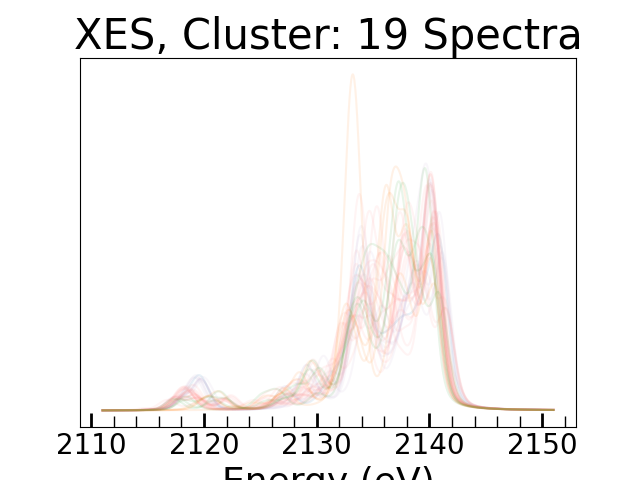

In [86]:
allowedclusters = (19,)
isolated_XES_data = [c for c in XES_data if XES_clustermap[c['CID']] in allowedclusters]
u.plot_spaghetti(plt.subplots(), isolated_XES_data, binmap=XES_clustermap, colormap=classcodemap, mode=f"XES, Cluster: {allowedclusters[0]}", coloralpha=0.1);

## Compare XES and XANES Clustering

In [142]:
XANES_listbycluster = {cluster: [c['CID'] for c in XANES_data if XANES_clustermap[c['CID']]==cluster] for cluster in range(len(set(XANES_clustering.labels_)))}

In [143]:
XES_listbycluster = {cluster: [c['CID'] for c in XES_data if XES_clustermap[c['CID']]==cluster] for cluster in range(len(set(XES_clustering.labels_)))}